# Import Libraries
Import all the necessary libraries for image processing, including PIL, numpy, sklearn, scipy, and matplotlib for visualization.

In [2]:
# Import necessary libraries for image processing and visualization
import os

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from scipy import ndimage
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Ensure matplotlib outputs are displayed inline in the notebook
%matplotlib inline

# Load Original Image
Load a sample image file and display it. Add functionality to upload custom images for testing.

FileUpload(value=(), accept='image/*', description='Upload')

Loaded sample image: /Users/lb/Downloads/images.png


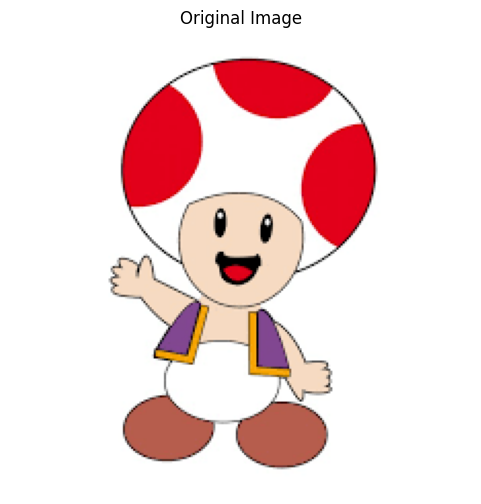

In [87]:
import ipywidgets as widgets
from IPython.display import display


# Function to load and display the original image
def load_image(image_path):
    image = Image.open(image_path)
    if image.mode != "RGB":
        image = image.convert("RGB")
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis("off")
    plt.title("Original Image")
    plt.show()
    return image

# File upload widget for custom image upload
upload_widget = widgets.FileUpload(
    accept="image/*",  # Accept image files only
    multiple=False     # Single file upload
)

# Callback function to handle image upload
def on_upload_change(change):
    if upload_widget.value:
        uploaded_file = list(upload_widget.value.values())[0]
        image_path = uploaded_file["name"]
        with open(image_path, "wb") as f:
            f.write(uploaded_file["content"])
        print(f"Loaded custom image: {image_path}")
        load_image(image_path)

# Display the upload widget
display(upload_widget)
upload_widget.observe(on_upload_change, names="value")

# Load and display a sample image if no custom image is uploaded
sample_image_path = "/Users/lb/Downloads/il_1588xN.3134377956_7ezh.jpg.webp"  # Replace with the path to your sample image
# sample_image_path = "/Users/lb/Downloads/castor-heureux-de-bande-dessinée-avec-du-bois-illustration-166814337.webp"  # Replace with the path to your sample image
sample_image_path = "/Users/lb/Downloads/images.png"  # Replace with the path to your sample image
# sample_image_path = "/Users/lb/Downloads/e350fd15c211417b6d899e0d6c345f2d.png"  # Replace with the path to your sample image
# sample_image_path = "/Users/lb/Downloads/images-4.jpeg"  # Replace with the path to your sample image
# sample_image_path = "/Users/lb/Downloads/images-3.png"  # Replace with the path to your sample image
if os.path.exists(sample_image_path):
    print(f"Loaded sample image: {sample_image_path}")
    original_image = load_image(sample_image_path)
else:
    print("Sample image not found. Please upload an image.")

# Center Image
Crop the image to focus on the image.

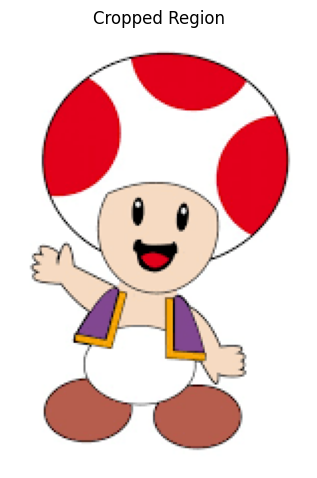

In [88]:
# Convert to numpy array if it's a PIL Image
import cv2

if isinstance(original_image, Image.Image):
    input_image = np.array(original_image)
else:
    input_image = original_image

height = input_image.shape[0]
width = input_image.shape[1]

# Checking image is grayscale or not. If image shape is 2 then gray scale otherwise not
if len(input_image.shape) == 2:
    gray_input_image = input_image.copy()
else:
    # Converting BGR image to grayscale image
    gray_input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)

# To find upper threshold, we need to apply Otsu's thresholding
upper_threshold, thresh_input_image = cv2.threshold(
    gray_input_image, thresh=0, maxval=255, type=cv2.THRESH_BINARY + cv2.THRESH_OTSU
)
# Calculate lower threshold
lower_threshold = 0.5 * upper_threshold

# Apply canny edge detection
canny = cv2.Canny(input_image, lower_threshold, upper_threshold)
# Finding the non-zero points of canny
pts = np.argwhere(canny > 0)

# Finding the min and max points
y1, x1 = pts.min(axis=0)
y2, x2 = pts.max(axis=0)

# Crop ROI from the givn image
BORDER = 10
x1 = max(x1 - BORDER, 0)
x2 = min(x2 + BORDER, width)
y1 = max(y1 - BORDER, 0)
y2 = min(y2 + BORDER, height)

cropped_region = input_image[y1:y2, x1:x2]

# Display the grid
plt.subplot(1, 2, 2)
plt.imshow(cropped_region)
plt.title("Cropped Region")
plt.axis("off")

plt.tight_layout()
plt.show()

# Create Grid
Divide the image into a grid of cells based on the specified board dimensions. Visualize the grid overlay on the resized image.

In [89]:
# Function to create and visualize the grid overlay
def create_grid(image, grid_width, grid_height):
    # Convert the image to a numpy array
    img_array = np.array(image)

    # Calculate the dimensions of each cell in the grid
    cell_width = img_array.shape[1] // grid_width
    cell_height = img_array.shape[0] // grid_height

    # Create a copy of the image array to draw the grid
    grid_image = img_array.copy()

    # Draw horizontal grid lines
    for y in range(1, grid_height):
        grid_image[y * cell_height : y * cell_height + 1, :] = [255, 0, 0]  # Red line

    # Draw vertical grid lines
    for x in range(1, grid_width):
        grid_image[:, x * cell_width : x * cell_width + 1] = [255, 0, 0]  # Red line

    # Visualize the grid overlay on the image
    plt.figure(figsize=(6, 6))
    plt.imshow(grid_image)
    plt.axis("off")
    plt.title("Image with Grid Overlay")
    plt.show()

# Detect the contour of the image content. (i.e. not unicolor background)
def define_zoi(image):
    """ """
# Define grid dimensions (number of cells in width and height)
grid_width = 50  # Use the same target dimensions as resizing
grid_height = 50

# Create and visualize the grid overlay
if 'resized_image' in locals():
    create_grid(original_image, grid_width, grid_height)
else:
    print("No resized image available to create a grid.")

No resized image available to create a grid.


# Split Image
Split the image into a grid of cells based on the specified dimensions. Each cell represents a potential peg in the final pegboard design. This step prepares the image for color analysis and processing.

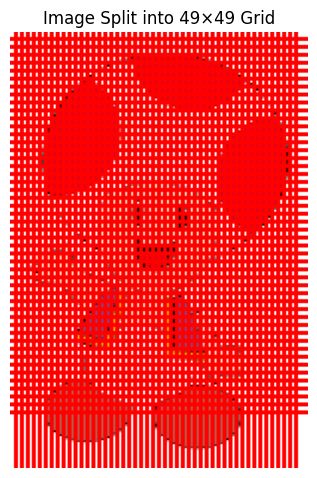

Total cells: 2401
Each cell dimensions: 3 x 4 pixels


In [90]:
def split_image_into_grid(image, grid_width, grid_height):
    """
    Split an image into a grid of equal-sized squares.
    
    Args:
        image: PIL Image object
        grid_width: Number of columns in the grid
        grid_height: Number of rows in the grid
        
    Returns:
        List of image patches in grid order
    """
    # Convert to numpy array if it's a PIL Image
    if isinstance(image, Image.Image):
        img_array = np.array(image)
    else:
        img_array = image

    # Calculate dimensions
    height, width = img_array.shape[:2]
    cell_height = (height - 1) // grid_height
    cell_width = (width - 1) // grid_width

    # Create a list to store the grid cells
    grid_cells = []

    # Extract each cell
    for y in range(grid_height):
        for x in range(grid_width):
            # Calculate cell boundaries
            y_start = y * cell_height
            y_end = (y + 1) * cell_height
            x_start = x * cell_width
            x_end = (x + 1) * cell_width

            # Extract the cell
            cell = img_array[y_start:y_end, x_start:x_end]
            grid_cells.append(cell)

    return np.array(grid_cells), cell_width, cell_height

# Define grid dimensions
# grid_width = 29 # Number of columns
# grid_height = 29  # Number of rows
grid_width = 49 # Number of columns
grid_height = 49  # Number of rows

# Split the image
grid_cells, cell_width, cell_height = split_image_into_grid(cropped_region, grid_width, grid_height)

# Create a new image to visualize the grid
grid_image = np.array(cropped_region.copy())
height, width = grid_image.shape[:2]

# Add grid lines
for i in range(1, grid_height):
    y = i * cell_height
    grid_image[y-1:y+1, :] = [255, 0, 0]  # Red horizontal lines

for i in range(1, grid_width):
    x = i * cell_width
    grid_image[:, x-1:x+1] = [255, 0, 0]  # Red vertical lines

# Display the grid
plt.subplot(1, 2, 2)
plt.imshow(grid_image)
plt.title(f"Image Split into {grid_width}×{grid_height} Grid")
plt.axis('off')

plt.tight_layout()
plt.show()

print(f"Total cells: {len(grid_cells)}")
print(f"Each cell dimensions: {cell_width} x {cell_height} pixels")

# Calculate Cell Colors
Calculate the average color for each cell in the grid. Display a visualization of the grid with each cell colored by its average color.

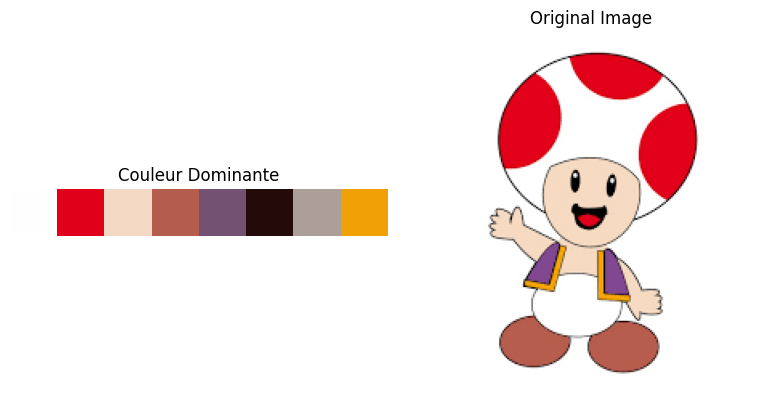

In [91]:
nr_couleur = 8  # Number of dominant colors to find

def get_dominant_colors(image, nr_couleur):
    """
    Get the dominant colors in an image using KMeans clustering.
    
    Args:
        image: PIL Image object
        nr_couleur: Number of dominant colors to find
    Returns:
        List of dominant colors
    """
    # Convert image to numpy array
    img_array = np.array(image)

    # Reshape the image for clustering
    clustering_image = img_array.reshape(img_array.shape[1]*img_array.shape[0], 3)

    # Initialize KMeans with the specified number of clusters
    kmeans = KMeans(n_clusters=nr_couleur, random_state=42)
    kmeans.fit(clustering_image)

    # Get the cluster centers (dominant colors)
    dominant_colors = kmeans.cluster_centers_.astype(int)
    labels = kmeans.labels_
    # Sort the dominant colors by the number of pixels in each cluster

    return dominant_colors, labels, kmeans


dominant_colors, labels, clustering_model = get_dominant_colors(cropped_region, nr_couleur)


# Count the number of pixels in each cluster
label_counts = np.bincount(labels)
# Sort the dominant colors by the number of pixels in each cluster
sorted_indices = np.argsort(label_counts)[::-1]
# Get the sorted dominant colors
sorted_dominant_colors = dominant_colors[sorted_indices]
# Display the dominant colors
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow([sorted_dominant_colors])
plt.axis("off")
plt.title("Couleur Dominante")
# Display the original image
plt.subplot(1, 2, 2)
plt.imshow(original_image)
plt.axis("off")
plt.title("Original Image")
plt.tight_layout()
plt.show()

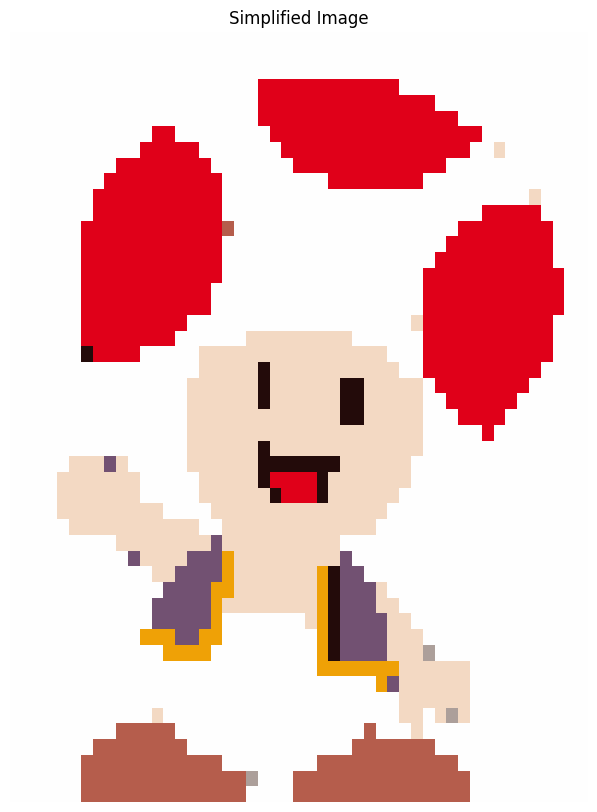

In [92]:
def simplify_cells_colors(grid_cell, kmeans):
    """
    Simplify the colors of grid cells based on the dominant colors.

    Args:
        grid_cell: a subset of the original image
        labels: Labels from KMeans clustering
        kmeans: KMeans model used for clustering
    Returns:
        Unicolor array of the grid cell
    """
    cell_height, cell_width = grid_cell.shape[:2]
    grid_cell = np.array(grid_cell)
    # predict the labels of the grid cell
    predicted_labels = kmeans.predict(
        grid_cell.reshape(cell_height * cell_width, 3)
    )
    # Find the most common label (dominant color)
    dominant_label = np.bincount(predicted_labels).argmax()

    # Get the corresponding color from the cluster centers
    dominant_color = kmeans.cluster_centers_[dominant_label].astype(int)

    # Create a uniform color array with the dominant color
    simplified_cell = np.full((cell_height, cell_width, 3), dominant_color, dtype=np.uint8)

    return simplified_cell


# Apply the color simplification to each grid cell
simplified_cells = []
for cell in grid_cells:
    simplified_cell = simplify_cells_colors(cell, clustering_model)
    simplified_cells.append(simplified_cell)

# Convert to numpy array with appropriate shape
simplified_cells_array = np.array(simplified_cells)

# Reshape to match the original grid structure
simplified_cells_grid = simplified_cells_array.reshape(grid_height, grid_width, cell_height, cell_width, 3)


# Reconstruct the simplified image
simplified_image = np.zeros((grid_height * cell_height, grid_width * cell_width, 3), dtype=np.uint8)
for i, cell in enumerate(simplified_cells):
    row = i // grid_width
    col = i % grid_width
    simplified_image[row*cell_height:(row+1)*cell_height, col*cell_width:(col+1)*cell_width] = cell

plt.figure(figsize=(10, 10))
plt.imshow(simplified_image)
plt.title("Simplified Image")
plt.axis('off')
plt.show()

Number of unique colors in the grid: 274


ValueError: RGBA values should be within 0-1 range

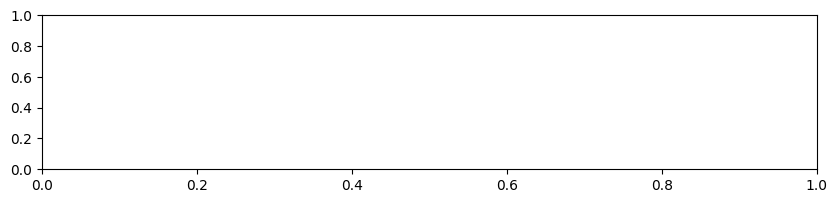

In [16]:
# Function to calculate and visualize average cell colors
def calculate_cell_colors(image, grid_width, grid_height):
    # Convert the image to a numpy array
    img_array = np.array(image)

    # Calculate the dimensions of each cell in the grid
    cell_width = img_array.shape[1] // grid_width
    cell_height = img_array.shape[0] // grid_height

    # Create an array to store the average color of each cell
    cell_colors = np.zeros((grid_height, grid_width, 3), dtype=np.uint8)

    # Calculate the average color for each cell
    for y in range(grid_height):
        for x in range(grid_width):
            y_start = y * cell_height
            y_end = (y + 1) * cell_height
            x_start = x * cell_width
            x_end = (x + 1) * cell_width

            # Extract the cell
            cell = img_array[y_start:y_end, x_start:x_end]

            # Calculate the average color of the cell
            if cell.size > 0:
                cell_colors[y, x] = np.mean(cell, axis=(0, 1)).astype(np.uint8)
            else:
                cell_colors[y, x] = [255, 255, 255]  # Default to white if empty

    # Visualize the grid with average cell colors
    plt.figure(figsize=(6, 6))
    plt.imshow(cell_colors)
    plt.axis("off")
    plt.title("Grid with Average Cell Colors")
    plt.show()

    return cell_colors

# Calculate and visualize average cell colors
# Use the grid cells to analyze color distribution
def analyze_color_distribution(grid_cells):
    # Extract the average color from each cell
    avg_colors = []
    for cell in grid_cells:
        if cell.size > 0:
            avg_color = np.mean(cell, axis=(0, 1)).astype(np.uint8)
            avg_colors.append(tuple(avg_color))

    # Count unique colors
    unique_colors = set(avg_colors)
    num_unique_colors = len(unique_colors)

    print(f"Number of unique colors in the grid: {num_unique_colors}")

    # Visualize color distribution
    plt.figure(figsize=(10, 2))
    plt.bar(range(min(20, num_unique_colors)),
            np.ones(min(20, num_unique_colors)),
            color=[color for color in list(unique_colors)[:20]])
    plt.title(f"Sample of Color Distribution (showing up to 20 out of {num_unique_colors} colors)")
    plt.xticks([])
    plt.yticks([])
    plt.show()

    return num_unique_colors, unique_colors

# If we already have grid_cells from previous calculation
if 'grid_cells' in locals():
    _, _ = analyze_color_distribution(grid_cells)
if 'resized_image' in locals():
    cell_colors = calculate_cell_colors(original_image, grid_width, grid_height)
else:
    print("No resized image available to calculate cell colors.")

# Resize Image
Implement the image resizing logic to fit within target dimensions while maintaining aspect ratio. Visualize the original and resized images side by side.

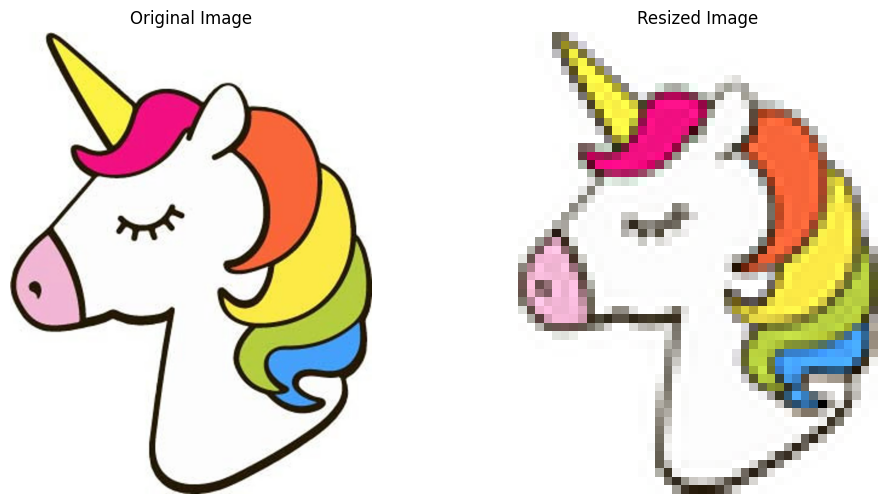

In [ ]:
# Resize Image

# Function to resize the image while maintaining aspect ratio
def resize_image(image, target_width, target_height, margin=2):
    # Add margin to target dimensions
    target_width_with_margin = target_width + 2 * margin
    target_height_with_margin = target_height + 2 * margin

    # Get current dimensions of the image
    current_width, current_height = image.size

    # Calculate scaling factor
    scale = min(
        target_width_with_margin / current_width,
        target_height_with_margin / current_height,
    )

    # Resize the image based on the scaling factor
    if scale < 1 or scale > 1.5:  # Resize only if necessary
        new_width = int(current_width * scale)
        new_height = int(current_height * scale)
        resized_image = image.resize((new_width, new_height), Image.Resampling.LANCZOS)
    else:
        resized_image = image

    return resized_image

# Define target dimensions for resizing
target_width = 50  # Replace with desired width in pegs
target_height = 50  # Replace with desired height in pegs

# Resize the image
if 'original_image' in locals():
    resized_image = resize_image(original_image, target_width, target_height)

    # Visualize the original and resized images side by side
    plt.figure(figsize=(12, 6))

    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.axis("off")
    plt.title("Original Image")

    # Resized image
    plt.subplot(1, 2, 2)
    plt.imshow(resized_image)
    plt.axis("off")
    plt.title("Resized Image")

    plt.show()
else:
    print("No image loaded. Please upload or provide an image.")

# Apply K-means Clustering
Implement K-means clustering to reduce the number of colors. Show the color palette before and after clustering, and visualize the image with the reduced color set.

In [ ]:
# Function to apply K-means clustering and visualize the results
def apply_kmeans_clustering(cell_colors, n_clusters):
    # Flatten the cell colors array for clustering
    flat_colors = cell_colors.reshape(-1, 3)

    # Normalize the colors for clustering
    scaler = StandardScaler()
    normalized_colors = scaler.fit_transform(flat_colors)

    # Apply K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(normalized_colors)

    # Get the clustered colors
    clustered_colors = scaler.inverse_transform(kmeans.cluster_centers_)
    clustered_colors = np.clip(clustered_colors, 0, 255).astype(np.uint8)

    # Map each cell to its cluster's color
    clustered_image = clustered_colors[kmeans.labels_].reshape(cell_colors.shape)

    # Visualize the original palette and clustered palette
    plt.figure(figsize=(12, 6))

    # Original palette
    plt.subplot(1, 2, 1)
    unique_colors = np.unique(cell_colors.reshape(-1, 3), axis=0)
    plt.imshow([unique_colors])
    plt.axis("off")
    plt.title("Original Color Palette")

    # Clustered palette
    plt.subplot(1, 2, 2)
    plt.imshow([clustered_colors])
    plt.axis("off")
    plt.title("Clustered Color Palette")

    plt.show()

    # Visualize the clustered image
    plt.figure(figsize=(6, 6))
    plt.imshow(clustered_image)
    plt.axis("off")
    plt.title("Image with Reduced Colors (K-means)")
    plt.show()

    return clustered_image

# Apply K-means clustering and visualize the results
if 'cell_colors' in locals():
    n_clusters = 16  # Define the number of colors to reduce to
    clustered_image = apply_kmeans_clustering(cell_colors, n_clusters)
else:
    print("No cell colors available to apply K-means clustering.")

# Create Pixelated Image
Create a pixelated version of the image using the clustered colors. Display the pixelated image alongside the original.

In [ ]:
# Function to create a pixelated version of the image using clustered colors
def create_pixelated_image(clustered_image, grid_width, grid_height, original_image):
    # Get the dimensions of the original image
    original_width, original_height = original_image.size

    # Calculate the dimensions of each cell in the grid
    cell_width = original_width // grid_width
    cell_height = original_height // grid_height

    # Create a blank image for the pixelated version
    pixelated_image = Image.new("RGB", (original_width, original_height))

    # Draw each cell with its corresponding clustered color
    for y in range(grid_height):
        for x in range(grid_width):
            # Get the color for the current cell
            color = tuple(clustered_image[y, x])

            # Draw the cell
            for py in range(cell_height):
                for px in range(cell_width):
                    pixelated_image.putpixel(
                        (x * cell_width + px, y * cell_height + py), color
                    )

    # Visualize the original and pixelated images side by side
    plt.figure(figsize=(12, 6))

    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.axis("off")
    plt.title("Original Image")

    # Pixelated image
    plt.subplot(1, 2, 2)
    plt.imshow(pixelated_image)
    plt.axis("off")
    plt.title("Pixelated Image")

    plt.show()

    return pixelated_image

# Create and visualize the pixelated image
if 'clustered_image' in locals() and 'resized_image' in locals():
    pixelated_image = create_pixelated_image(clustered_image, grid_width, grid_height, resized_image)
else:
    print("No clustered image or resized image available to create a pixelated image.")

# Apply Edge Detection
Implement edge detection using Sobel filters. Show the edge detection results and the image with edges overlaid.

In [ ]:
# Function to apply edge detection using Sobel filters and visualize the results
def apply_edge_detection(pixelated_image):
    # Convert the pixelated image to a numpy array
    img_array = np.array(pixelated_image)

    # Convert the image to grayscale for edge detection
    gray = np.dot(img_array[..., :3], [0.2989, 0.5870, 0.1140])

    # Apply Sobel filters for edge detection
    sobel_h = ndimage.sobel(gray, axis=0)  # Horizontal edges
    sobel_v = ndimage.sobel(gray, axis=1)  # Vertical edges

    # Combine the gradients to get the edge magnitude
    edge_magnitude = np.sqrt(sobel_h**2 + sobel_v**2)

    # Normalize the edge magnitude to the range [0, 255]
    edge_magnitude = (edge_magnitude / edge_magnitude.max() * 255).astype(np.uint8)

    # Visualize the edge detection results
    plt.figure(figsize=(12, 6))

    # Original pixelated image
    plt.subplot(1, 2, 1)
    plt.imshow(pixelated_image)
    plt.axis("off")
    plt.title("Pixelated Image")

    # Edge detection result
    plt.subplot(1, 2, 2)
    plt.imshow(edge_magnitude, cmap="gray")
    plt.axis("off")
    plt.title("Edge Detection (Sobel)")

    plt.show()

    return edge_magnitude

# Function to overlay edges on the pixelated image
def overlay_edges(pixelated_image, edge_magnitude, edge_threshold=50):
    # Create a copy of the pixelated image
    overlay_image = np.array(pixelated_image).copy()

    # Threshold the edge magnitude to create a binary edge map
    edges = edge_magnitude > edge_threshold

    # Overlay the edges on the pixelated image (set edge pixels to black)
    overlay_image[edges] = [0, 0, 0]

    # Visualize the image with edges overlaid
    plt.figure(figsize=(6, 6))
    plt.imshow(overlay_image)
    plt.axis("off")
    plt.title("Image with Edges Overlaid")
    plt.show()

    return overlay_image

# Apply edge detection and overlay edges
if 'pixelated_image' in locals():
    edge_magnitude = apply_edge_detection(pixelated_image)
    image_with_edges = overlay_edges(pixelated_image, edge_magnitude)
else:
    print("No pixelated image available to apply edge detection.")